##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [117]:
%pip install pandas 
%pip install matplotlib
%pip install numpy
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [118]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [119]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import joblib

## Preprocessing

In [120]:
df = pd.read_csv(filepath)

# Specify columns to drop
columns_to_drop = ["error", "Fiscal Year End", "Sales (Global Ultimate Total USD)", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                   "Sales (Global Ultimate Total USD)", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Address","LATITUDE", "LONGITUDE", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company",
                  "Ownership Type"]

def drop_columns(df):
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    return df    

def preprocess(df, test=True):
    training_df = pd.read_csv(filepath)
    # Drop columns if they exist in the DataFrame
    if not test:
        df = df[df['Company Status (Active/Inactive)'] == 'Active']
    df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()
    if not test:
        df = df.dropna(subset=[
            "Employees (Single Site)",
            "Employees (Domestic Ultimate Total)",
            "Employees (Global Ultimate Total)",
            "Year Found"])
    df = pd.get_dummies(df, columns=['Entity Type'], prefix='Entity_Type')
    # df = pd.get_dummies(df, columns=['Ownership Type'], prefix='Ownership_Type')
    df = pd.get_dummies(df, columns=['Import/Export Status'], prefix='Import_Export_Status')
    df = df.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df.columns], errors='ignore') # are all Active
    
    sic_code_frequency = training_df['SIC Code'].value_counts()
    
    # Set a threshold for low-frequency SIC Codes
    threshold = 7  # Adjust this threshold based on your preference
    
    # Identify SIC Codes with frequency below the threshold
    low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index    
    # Replace these low-frequency SIC Codes with a common label "Others"
    df['SIC Code'] = df['SIC Code'].replace(low_frequency_sic_codes, 'Others')
    df['SIC Code'] = df['SIC Code'].astype(str)
    training_df['SIC Code'] = training_df['SIC Code'].replace(low_frequency_sic_codes, 'Others')
    training_df['SIC Code'] = training_df['SIC Code'].astype(str)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(training_df['SIC Code'])
    df['SIC Code'] = label_encoder.transform(df['SIC Code'])
    return df

df = preprocess(df, test=False)
df = drop_columns(df)
df['Sales (Domestic Ultimate Total USD)'] = np.log10(df['Sales (Domestic Ultimate Total USD)'].clip(lower=1))

X = df.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


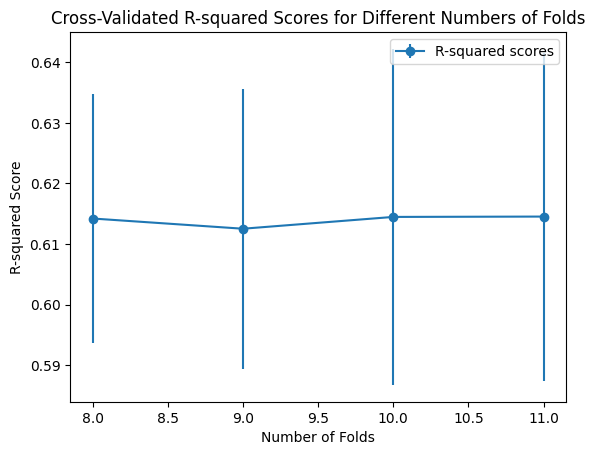

Cross-Validation R-squared scores: [0.67608421 0.60599276 0.57806253 0.64124794 0.59213604 0.59743924
 0.6158254  0.62627628 0.58711696 0.62458442]
Mean R-squared score: 0.6144765776425765
Standard Deviation of R-squared scores: 0.027733200245781284
Test R-squared score: 0.6072228655837473


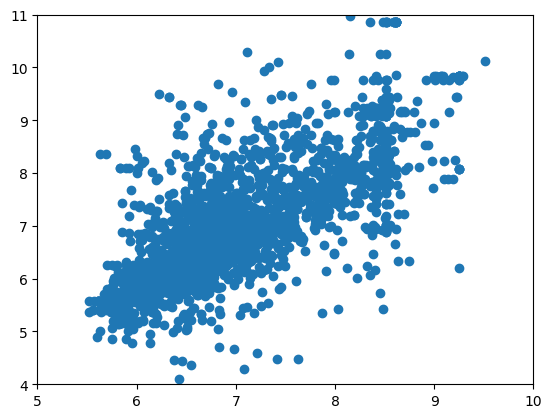

In [121]:
# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

n_folds_values = list(range(8, 12))
mean_r2_scores = []
std_r2_scores = []

# Iterate over different numbers of folds
for n_folds in n_folds_values:
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

model_10 = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
model_10.fit(X_train, y_train)

# Save the base model to an HDF5 file
joblib.dump(model_10, 'base_model.h5')

# Evaluate the model on the test set
test_score = model_10.score(X_test, y_test)
print("Test R-squared score:", test_score)

# plt.scatter(np.log10(model_10.predict(X_test)), np.log10(y_test))
plt.xlim(5, 10)
plt.ylim(4, 11)
plt.scatter(model_10.predict(X_test), y_test)

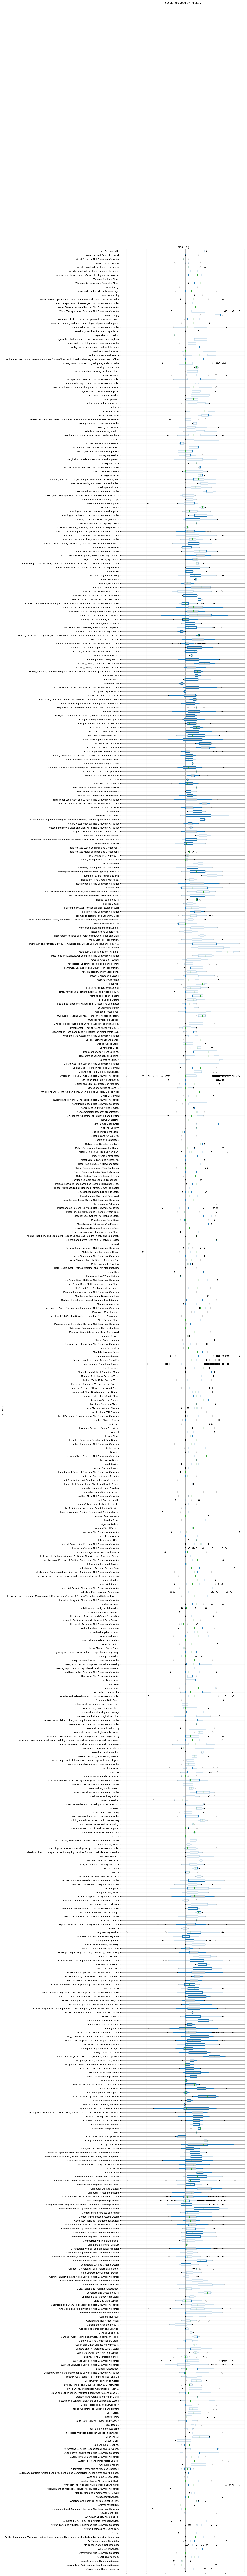

In [122]:
df = pd.read_csv(filepath)
df['Sales (Log)'] = np.log10(df['Sales (Domestic Ultimate Total USD)'].clip(lower=1))
box = df.boxplot(column=['Sales (Log)'], by='Industry', vert=False, figsize=(10, 200)) 

## Analysing the distribution of Sales figures

From the histograms we can see that the sales figures are highly skewed and over a large range, which could cause issues when using correlation since correlation coefficients assume linear range.

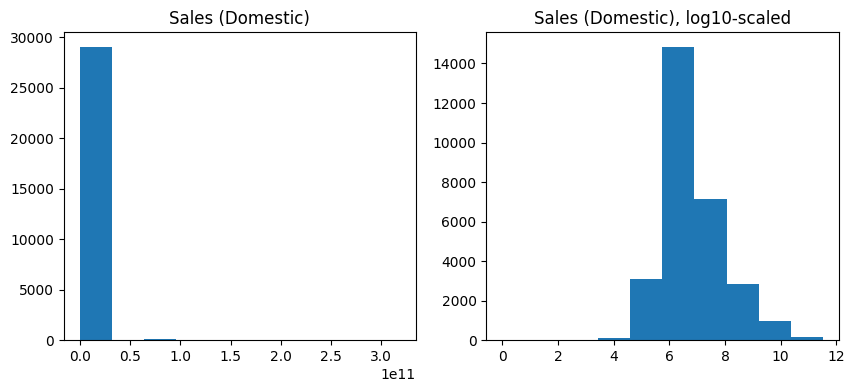

In [123]:
df = pd.read_csv(filepath)
plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Sales (Domestic)')
h1 = plt.hist(df['Sales (Domestic Ultimate Total USD)'])
plt.subplot(1, 2, 2)
plt.title('Sales (Domestic), log10-scaled')
h2 = plt.hist(np.log10(df['Sales (Domestic Ultimate Total USD)'].clip(lower=1)))

SIC Code
8742.0    1389
7371.0     778
4731.0     737
7389.0     694
5099.0     668
8711.0     580
6552.0     580
4499.0     554
5812.0     527
Name: count, dtype: int64


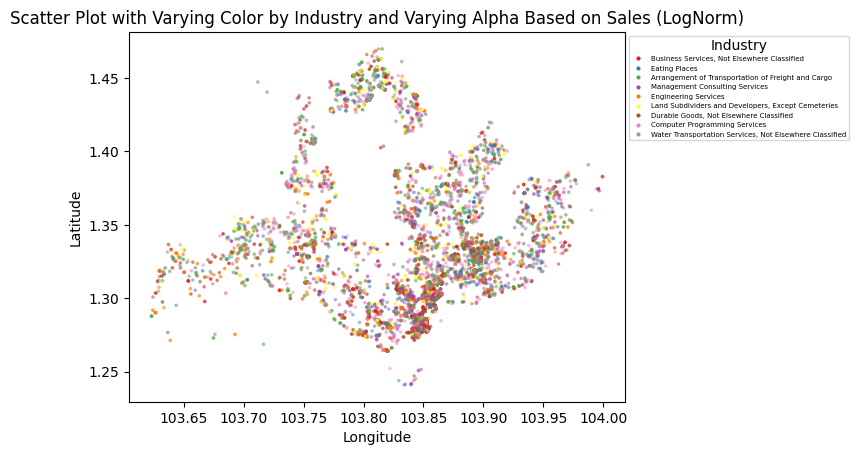

In [124]:
# import required libraries
import matplotlib.pyplot as plt

# we will need this for the color gradient representing how high the domestic sales figure is.
from matplotlib.colors import LogNorm
import seaborn as sns

df = pd.read_csv(filepath)

codes = df['SIC Code'].value_counts()
codes = codes[codes > 500]
codes = codes[codes < 2000]

print(codes)
filtered_df = df[df['SIC Code'].isin(codes.keys())]

filtered_df.head(2)

# read in the filtered dataset and do EDA. confusion matrix, etc

# Use LogNorm for more sensitivity to numerical changes
norm = LogNorm()

# Define a constant color (e.g., blue)
constant_color = 'blue'

# Define a color palette based on unique industries
industry_palette = sns.color_palette('Set1', n_colors=len(filtered_df['Industry'].unique()))

# Create a dictionary to map Industry to a unique color
industry_colors = dict(zip(filtered_df['Industry'].unique(), industry_palette))

# Scatter plot with varying color by Industry and varying alpha based on Sales values
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], c=filtered_df['Industry'].map(industry_colors), s=3, alpha=norm(filtered_df['Sales (Domestic Ultimate Total USD)']))

# Add a legend for Industry
legend_labels = filtered_df['Industry'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry,
                              markerfacecolor=industry_colors[industry], markersize=4) for industry in legend_labels]
plt.legend(handles=legend_handles, title='Industry', prop={'size': 5}, loc='upper left', bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Varying Color by Industry and Varying Alpha Based on Sales (LogNorm)')

# Show the plot
plt.show()


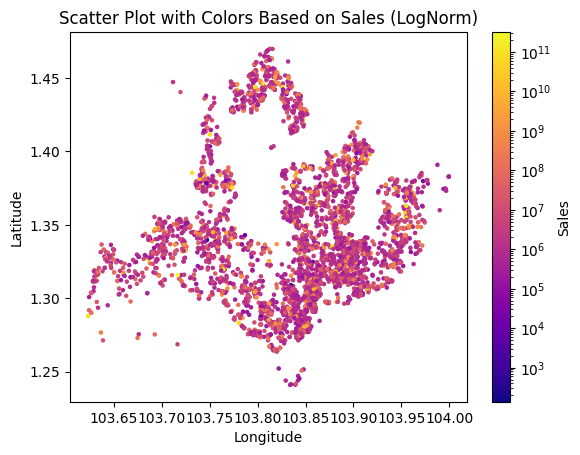

In [125]:
# Use LogNorm for more sensitivity to numerical changes
norm = LogNorm()

# Define a colormap transitioning from blue to red
cmap = 'plasma'

# Scatter plot with colors based on Sales values and LogNorm
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], c=filtered_df['Sales (Domestic Ultimate Total USD)'], cmap=cmap, s=5, norm=norm)

# Add a colorbar
cbar = plt.colorbar(scatter, label='Sales')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')

# Show the plot
plt.show()

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [126]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    import joblib
    import numpy as np
    hidden_data = preprocess(hidden_data)
    hidden_data = drop_columns(hidden_data)
    loaded_model = joblib.load('./base_model.h5')
    predictions = loaded_model.predict(hidden_data)

    result = np.power(10, predictions)
    return result

##### Cell to check testing_hidden_data function

In [130]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath) # .drop(columns=columns_to_drop).dropna()
test_df = drop_columns(test_df).dropna()
y = test_df['Sales (Domestic Ultimate Total USD)']
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[5.55508199e+06 1.01706920e+08 5.04007199e+08 ... 3.99679045e+06
 5.76826989e+07 2.25775395e+07]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!